C:\Users\Ruben\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


AppLayout(children=(HTML(value='<br><br><br><b><font size=4>Potentiel annuel de production PV [MWh] par sous s…

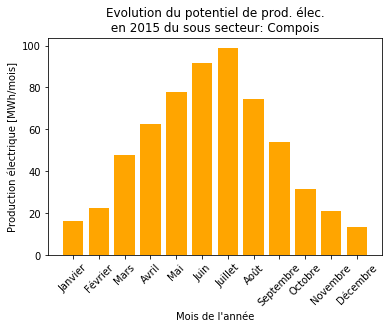

In [4]:
import ipyleaflet
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from branca.colormap import linear
from IPython.display import display
import json
import requests
import io
import base64
from sklearn.metrics import mean_squared_error, r2_score
sous_sect_geojson = 'GEO_GIREC_WGS84.geojson'
with open(sous_sect_geojson, 'rb') as f:
    geo_json_data = json.load(f)

# Les éléments ont besoin d'avoir un champ "id" qui correspond au champ "NUMERO" pour créer la carte
for f in geo_json_data['features']:
    f['id'] = f['properties']['NUMERO'] 
# Importation des fichiers
ss_data = pd.read_csv('PV_sous_secteur.csv',dtype= {'NUMERO': 'str'})
noms_ss = pd.read_csv('Noms_sous_secteur.csv',dtype= {'NUMERO': 'str','NOM': 'str'})
Prod_PV_SS = pd.read_csv('Bats_sous_sect_PV.csv', sep=",", index_col="NOM")

# Création d'un dictionnaire pour faire la carte choropleth
ss_data_dict = ss_data.set_index('NUMERO')['xP_Tot_MWh'].to_dict()

   

sous_secteur = noms_ss.merge(ss_data, left_on = ['NUMERO'], right_on = ['NUMERO'])


Prod_PV_SS.drop(Prod_PV_SS.iloc[:,0:36], inplace = True, axis = 1)
Prod_PV_SS.drop(Prod_PV_SS.iloc[:,365:], inplace = True, axis = 1)

for col in Prod_PV_SS:
    Prod_PV_SS[col] = Prod_PV_SS[col]/1000

transpo_2015 = pd.read_csv('Transposition_2015.csv', sep=";",index_col="jours")
for col in transpo_2015:
    transpo_2015[col] = transpo_2015[col]*24/1000

transpo_2015.drop(transpo_2015.iloc[:,1:], inplace = True, axis = 1)
rayo_Gh = transpo_2015.copy()
rayo_Gh.index = Prod_PV_SS.columns
Prod_PV_SS_divided = Prod_PV_SS / rayo_Gh['0_0']
ss_data_2 = ss_data.copy()
col_cal = ss_data_2.loc[:,'x1':'x365']
for col in col_cal:
    ss_data_2[col] = ss_data_2[col] / ss_data_2['xs_mob_PV']
# Création des noms de type de graphiques
List_graphs = ["1 - Prod. élec.[MWh/mois] / mois",
                       "2 - Prod. élec. [kWh/jour] / jour",
                       "3 - Prod. élec [MWh/jour] / Gh",
                       "4 - Prod. élec [kWh/m2/jour] / Gh"]
select_graph_type = widgets.Select(name='Select', options=List_graphs)

# Définition du sous secteur par défaut (variables globales)
SS_DEFAUT = noms_ss.NOM.iloc[0]
MOUSE_IN_SS = noms_ss.NOM.iloc[0]
# Set the default chart type
CHART_TYPE = List_graphs[0]

# DEBUG VIEW
# FIXME: debug view est nécessaire pour cacher la sortie supplémentaire lorsque l'utilisateur change le type de graphique
debug_view = widgets.Output(layout={'border': '1px solid black', 
                                    'min_height':'100px'})
    
# Permet d'appeler la bonne fonction en fonction du choix de l'utilisateur
@debug_view.capture(clear_output=True)
def update_chart(chart_type):
    global CHART_TYPE
    CHART_TYPE = chart_type
    if chart_type == '1 - Prod. élec.[MWh/mois] / mois':
        plot_data_1()
    elif chart_type == '2 - Prod. élec. [kWh/jour] / jour':
        plot_data_2()
    elif chart_type == '3 - Prod. élec [MWh/jour] / Gh':
        plot_data_3()
    elif chart_type == '4 - Prod. élec [kWh/m2/jour] / Gh':    
        plot_data_4()
    else:
        pass
    pass

# Widget interactif pour lier le choix du graph et la sortie de la fonction update_chart
chart_type_output = widgets.interactive_output(update_chart, {'chart_type': select_graph_type})

caption = widgets.HTML(value='')

# Création des fonctions pour les graphiques
def plot_data_1():
    tt = (sous_secteur.loc[sous_secteur['NOM']==SS_DEFAUT]).T
    moi = {'xP_01':'Janvier', 'xP_02':'Février', 'xP_03':'Mars', 'xP_04':'Avril', 'xP_05':'Mai', 'xP_06':'Juin',
           'xP_07':'Juillet', 'xP_08':'Août', 'xP_09':'Septembre', 'xP_10':'Octobre',
           'xP_11':'Novembre', 'xP_12':'Décembre'}
    mois = pd.Series(moi)
    df = tt[392:404]
    df2 = df.T.squeeze() 
    with chart_type_output:
        chart_type_output.clear_output()
        f, ax = plt.subplots()
        ax.bar(mois,(df2/1000),color='orange')
        plt.xticks(rotation=45)
        ax.set(
            title = f'Evolution du potentiel de prod. élec.\n en 2015 du sous secteur: {SS_DEFAUT} ',
            xlabel = "Mois de l'année",
            ylabel = 'Production électrique [MWh/mois]')
        display(f)

def plot_data_2():
    jours = pd.Series(range (1, 366))   
    tt = (sous_secteur.loc[sous_secteur['NOM']==SS_DEFAUT]).T
    with chart_type_output:
        chart_type_output.clear_output()
        f, ax = plt.subplots()
        ax.plot(jours,tt[27:392], color='black')
        ax.set(
            title = f'Evolution du potentiel de prod. élec.\n en 2015 du sous secteur: {SS_DEFAUT} ',
            xlabel = "Jours de l'année",
            ylabel = 'Production électrique [kWh/jour]')
        display(f)

def plot_data_3():
    tt = (sous_secteur.loc[sous_secteur['NOM']==SS_DEFAUT]).T 
    tt_final = tt[27:392].astype('float64')
    x = np.array(rayo_Gh)[:,0]
    y = np.array((tt_final/1000))[:,0]
    x = x[:,np.newaxis]
    m = np.linalg.lstsq(x, y, rcond=None)[0]
    y_pred = x*m
    r2 = r2_score(y,y_pred)
    with chart_type_output:
        chart_type_output.clear_output()  
        f, ax = plt.subplots()   
        ax.scatter(x, y, color='#0000ff55', label='Données')
        ax.set(
            title = f'Relation entre la prod. élec.\n et RGh en 2015 du sous secteur: {SS_DEFAUT} ',
            xlabel = "Rayonnement global horizontal [kWh/m\u00b2/jour]",
            ylabel = 'Production électrique [MWh/jour]')  
        ax.plot(x, m*x,'r', label='Droite de regression') 
        ax.annotate('y = {:.3f}*x\nR\u00b2: {:.4f}'.format(m[0],r2),xy=(1, 1), xytext=(-15, -15), fontsize=10,
                    xycoords='axes fraction', textcoords='offset points',
                    bbox=dict(facecolor='white', alpha=0.8), horizontalalignment='right', verticalalignment='top')
        _ = plt.legend()
        display(f)        

def plot_data_4():
    zz = (ss_data_2.loc[sous_secteur['NOM']==SS_DEFAUT]).T
    zz_final = zz[25:390].astype('float64')
    f, ax = plt.subplots()
    x = np.array(rayo_Gh)[:,0]
    y = np.array((zz_final))[:,0]
    x = x[:,np.newaxis]
    m = np.linalg.lstsq(x, y, rcond=None)[0]
    y_pred = x*m
    r2 = r2_score(y,y_pred)
    with chart_type_output:
        chart_type_output.clear_output()
        ax.scatter(x, y, color='#0000ff55', label='Données')
        ax.set(
            title = f'Relation entre la prod. élec. par m\u00b2 de capteur\n et RGh en 2015 du sous secteur: {SS_DEFAUT} ',
            xlabel = "Rayonnement global horizontal [kWh/m\u00b2/jour]",
            ylabel = 'Production électrique [kWh/m\u00b2/jour]')  
        ax.plot(x, m*x,'r', label='Droite de regression')
        ax.annotate('y = {:.3f}*x\nR\u00b2: {:.4f}'.format(m[0],r2),xy=(1, 1), xytext=(-15, -15), fontsize=10,
                    xycoords='axes fraction', textcoords='offset points',
                    bbox=dict(facecolor='white', alpha=0.8), horizontalalignment='right', verticalalignment='top')
        _ = plt.legend()
        display(f)         
        
# Fonction pour le survol de la carte avec la souris
# Permet lors du survol de créer un dictionnaire avec le nom du ss
def map_hover(event, **feature):
    global MOUSE_IN_SS
    MOUSE_IN_SS = feature['properties']['NOM']
    caption.value = f'Le sous secteur sélectionné est:<br> <b>{SS_DEFAUT}</b>'
    
# Fonction lors du click avec la souris
# Permet lors du click de créer un dictionnaire avec le nom du ss et de mettre à jour le graph'
def map_click(event, **feature):
    if event == 'click':
        global SS_DEFAUT
        SS_DEFAUT = MOUSE_IN_SS
        caption.value = f'Le sous secteur sélectionné est:<br> <b>{SS_DEFAUT}</b>'
        update_chart(CHART_TYPE)    
                
# Création d'un bouton pour exporter fichier en csv 
button_csv = widgets.Button(
    description='Exporter en CSV',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check'
)  
        
# Création d'une fonction pour exporter en csv les données du sous secteur sélectionné
def export_csv(event):
    tt = (sous_secteur.loc[sous_secteur['NOM']==SS_DEFAUT])
    f = io.StringIO()
    tt.to_csv(f)
    base64_csv = base64.urlsafe_b64encode(f.getvalue().encode('utf8'))
    base64_csv = str(base64_csv, "utf-8")
    download_link = f"""<a download='{SS_DEFAUT}.csv' href='data:text/csv;charset=utf-8;base64,{base64_csv}'>Download {SS_DEFAUT}.csv</a>"""
    
    with link_space:
        display(widgets.HTML(download_link))
    
link_space = widgets.Output()        
button_csv.on_click(export_csv)  

# Cartographie
base_map = ipyleaflet.Map(center=[46.24, 6.14],
    zoom_start=11, control_scale=True)
choro_map = ipyleaflet.Choropleth(
    geo_data=geo_json_data,
    choro_data=ss_data_dict,
    colormap=linear.YlOrRd_07,
    legendmap='d',
    border_color='black',
    style={'fillOpacity': 0.75, 'dashArray': '6'},
    hover_style={'fillColor': 'blue' , 'fillOpacity': 0.9}
)
base_map.add_layer(choro_map)

Max = int(ss_data['xP_Tot_MWh'].max())
Min = int(ss_data['xP_Tot_MWh'].min())
legend = linear.YlOrRd_07.scale(Min,Max).to_step(4)
out = widgets.Output(layout={'border': '1px solid black'})
with out:
    display(legend)

widget_control = ipyleaflet.WidgetControl(widget=out, position='bottomleft')
base_map.add_control(widget_control)

choro_map.on_hover(map_hover)       
choro_map.on_click(map_click)

caption_2 = widgets.HTML(
    value=f"<br><br><br><b><font size=4>Potentiel annuel de production PV [MWh] par sous secteur</font>"
       #value=f"<br><br><br><b>Potentiel annuel de production PV [MWh] par sous secteur</b>",
)

# Rendu graphique et interactif final
# FIXME: debug view est nécessaire pour cacher la sortie supplémentaire lorsque l'utilisateur change le type de graphique
chart_area = widgets.VBox([
    caption,
    button_csv,
    link_space, 
    select_graph_type,
    chart_type_output,
])

widgets.AppLayout(header=caption_2,
          left_sidebar=None,
          center=base_map,
          right_sidebar=chart_area, #footer=debug_view
)